In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_hr_plot(model,Xtr,Ytr,filename=None):
    
    x=np.linspace(0,1,100)
    x=x.reshape((100,1))
    m=model.mean(torch.tensor(x,dtype=torch.float32)).detach().numpy().flatten()
    s=model.std(torch.tensor(x,dtype=torch.float32)).detach().numpy().flatten()

    plt.plot(Xtr,Ytr,"k.")
    plt.plot(x.flatten(),m,'b' )
    plt.fill_between(x.flatten(),m-2*s,m+2*s,alpha=0.5)
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(["Data","Mean","2 Std"])
    if filename is not None:
        plt.savefig(filename)
    plt.show() 

In [3]:
class hr(nn.Module):

    def __init__(self,D,K,epoch=100,lr=0.01):
        #D: dimension
        #K: length of layer
        super(hr, self).__init__()
        self.D=D
        self.K=K
        self.epoch=epoch
        self.lr=lr
        self.optim_params=None
        self.loss_list=[]

        self.mean_nn=nn.Sequential(
            nn.Linear(self.D,self.K),
            nn.Sigmoid(),
            nn.Linear(self.K,1)
        )
        self.std_nn=nn.Sequential(
            nn.Linear(self.D,1),
            nn.Softplus()
        )
    
    def set_params(self,W1,b1,W2,b2,V1,c1):
        self.mean_nn[0].weight= nn.Parameter(torch.reshape(W1,torch.Size([self.K, self.D])))
        self.mean_nn[0].bias= nn.Parameter(torch.reshape(b1,torch.Size([self.K])))
        self.mean_nn[2].weight = nn.Parameter(torch.reshape(W2,torch.Size([1, self.K])))
        self.mean_nn[2].bias = nn.Parameter(torch.reshape(b2,torch.Size([1])))
        self.std_nn[0].weight = nn.Parameter(torch.reshape(V1,torch.Size([1, self.D])))
        self.std_nn[0].bias = nn.Parameter(torch.reshape(c1,torch.Size([1])))
        
        
    def mean(self,X):
        return self.mean_nn(X)
    
    def std(self,X):
        return self.std_nn(X)
    
    def nll(self,X,Y):
        means=self.mean(X)
        vars=self.std(X)**2
        ndist=torch.distributions.Normal(means,vars)
        nll=-ndist.log_prob(Y).sum()
        return nll
    
    def fit(self,X,Y,initialize_weights=True):
        if initialize_weights:
            self.mean_nn.apply(self.init_weights)
            self.std_nn.apply(self.init_weights)
            #self.print_param()
        optimizer=optim.Adam(self.parameters(),lr=self.lr)
        for epoch in range(self.epoch):
            loss=self.nll(X,Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            self.loss_list.append(loss.item())
            #print(f'Epoch:{epoch}   Loss:{loss.item()}')
        self.optim_params=self.parameters
        return loss.item()
    
    def init_weights(self,m):
        classname = m.__class__.__name__
        # for every Linear layer in a model
        if classname.find('Linear') != -1:
            y = m.in_features
            m.weight.data.normal_(0.0,1/np.sqrt(y))
            m.bias.data.normal_(0.0,0.1)
    
    def print_param(self):
        for param in self.parameters():
            print(f'parameter shape:{param.shape}')
            print(f'parameter value:{param.data}')

In [4]:
#Load the data
data = np.load("./data/hr_data.npz")
Xtr=torch.tensor(data["Xtr"],dtype=torch.float32)
Xte=torch.tensor(data["Xte"],dtype=torch.float32)
Ytr=torch.tensor(data["Ytr"],dtype=torch.float32)
Yte=torch.tensor(data["Yte"],dtype=torch.float32)

#Load the parameters
params = np.load("./data/hr_params.npz")
W1=torch.tensor(params["W1"],dtype=torch.float32)
b1=torch.tensor(params["b1"],dtype=torch.float32)
W2=torch.tensor(params["W2"],dtype=torch.float32)
b2=torch.tensor(params["b2"],dtype=torch.float32)
V1=torch.tensor(params["V1"],dtype=torch.float32)
c1=torch.tensor(params["c1"],dtype=torch.float32)

print()

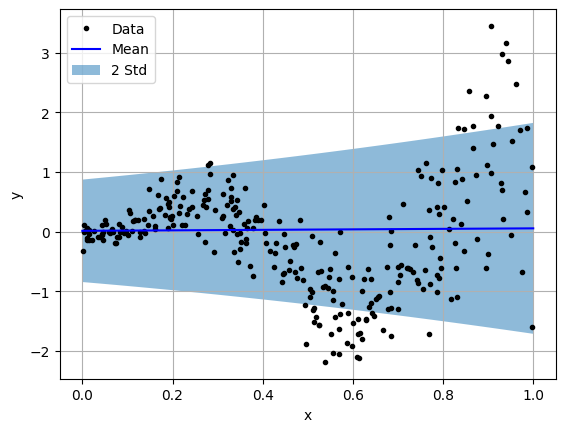

In [5]:
model=hr(1,3)
make_hr_plot(model,Xtr,Ytr)


### a

In [6]:
model.set_params(W1,b1,W2,b2,V1,c1)
means=model.mean(Xtr)
print(means[0:5])

tensor([[ 0.9935],
        [-0.0818],
        [ 1.2234],
        [ 1.7484],
        [-0.3340]], grad_fn=<SliceBackward0>)


### b

In [7]:
model.set_params(W1,b1,W2,b2,V1,c1)
stds=model.std(Xtr)
print(stds[0:5])

tensor([[1.7839],
        [1.4218],
        [1.8674],
        [2.0829],
        [1.3326]], grad_fn=<SliceBackward0>)


### c

In [8]:
model.set_params(W1,b1,W2,b2,V1,c1)
nll=model.nll(Xtr,Ytr)
print(nll.item())

609.3236694335938


### d

In [9]:
epochs=[50,100,500,1000,1500,2000,2500,5000]
lrs=[1,1e-1,1e-2,1e-3,1e-4,1e-5]
loss_epoch=[]
for epoch in epochs:
    loss_lr=[]
    for lr in lrs:
        model=hr(1,5,epoch,lr)
        loss=model.fit(Xtr,Ytr,False)
        loss_lr.append(loss)
        print(f'Epoch:{epoch}   lr: {lr}    Loss:{loss}')
    loss_epoch.append(loss_lr)
print(loss_epoch)

Epoch:50   lr: 1    Loss:317.4474182128906
Epoch:50   lr: 0.1    Loss:308.8958740234375
Epoch:50   lr: 0.01    Loss:967.818115234375
Epoch:50   lr: 0.001    Loss:392.2590026855469
Epoch:50   lr: 0.0001    Loss:415.28546142578125
Epoch:50   lr: 1e-05    Loss:93210.765625
Epoch:100   lr: 1    Loss:459.01751708984375
Epoch:100   lr: 0.1    Loss:307.11029052734375
Epoch:100   lr: 0.01    Loss:474.64544677734375
Epoch:100   lr: 0.001    Loss:765.3196411132812
Epoch:100   lr: 0.0001    Loss:3184.041259765625
Epoch:100   lr: 1e-05    Loss:472.60626220703125
Epoch:500   lr: 1    Loss:312.7330627441406
Epoch:500   lr: 0.1    Loss:169.13096618652344
Epoch:500   lr: 0.01    Loss:225.3402099609375
Epoch:500   lr: 0.001    Loss:336.1192321777344
Epoch:500   lr: 0.0001    Loss:854.0441284179688
Epoch:500   lr: 1e-05    Loss:4340.2724609375
Epoch:1000   lr: 1    Loss:316.20697021484375
Epoch:1000   lr: 0.1    Loss:166.90756225585938
Epoch:1000   lr: 0.01    Loss:170.49801635742188
Epoch:1000   lr: 0.

In [10]:
optimal_epoch=1500
optimal_lr=0.1

In [17]:
loss_lists_tr=[]
loss_lists_te=[]
model_list_tr=[]
for i in range(5):
    model_tr=hr(1,5,optimal_epoch,optimal_lr)
    loss_tr=model_tr.fit(Xtr,Ytr)
    model_list_tr.append(model_tr)
    loss_lists_tr.append(model_tr.loss_list)
    model_te=hr(1,5,optimal_epoch,optimal_lr)
    loss_te=model_te.fit(Xte,Yte)
    loss_lists_te.append(model_te.loss_list)
    

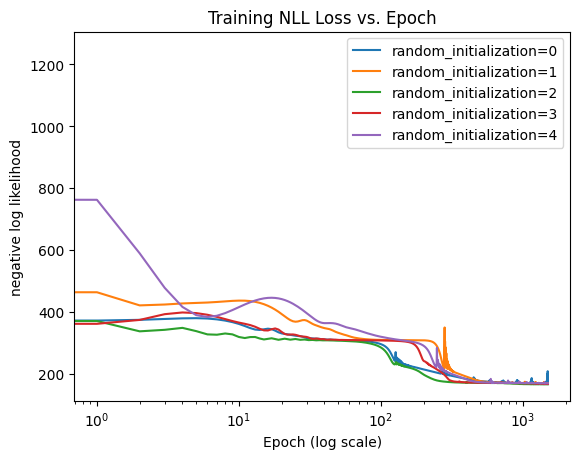

In [18]:
import matplotlib.pyplot as plt

values = [i for i in range(optimal_epoch)]

for i in range(len(loss_lists_tr)):
    plt.plot(values, loss_lists_tr[i], label=f"random_initialization={i}")

plt.xlabel('Epoch (log scale)')
plt.ylabel('negative log likelihood')
plt.title('Training NLL Loss vs. Epoch')
plt.legend()
plt.xscale('log')
plt.show()

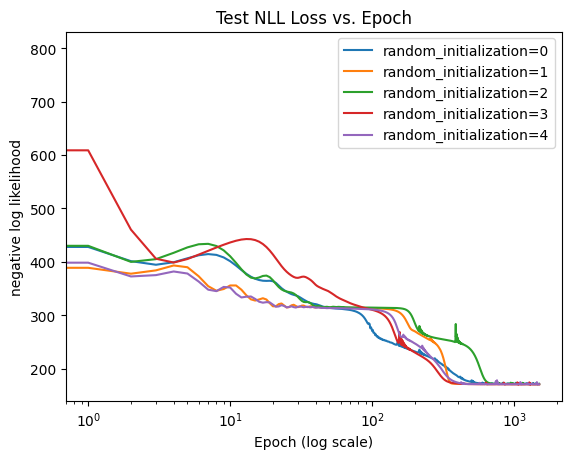

In [19]:
import matplotlib.pyplot as plt

values = [i for i in range(optimal_epoch)]

for i in range(len(loss_lists_te)):
    plt.plot(values, loss_lists_te[i], label=f"random_initialization={i}")

plt.xlabel('Epoch (log scale)')
plt.ylabel('negative log likelihood')
plt.title('Test NLL Loss vs. Epoch')
plt.legend()
plt.xscale('log')
plt.show()

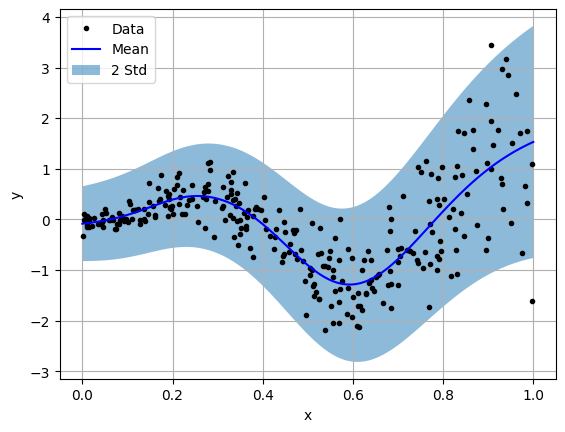

In [21]:
make_hr_plot(model_list_tr[4],Xtr,Ytr)